## 2D Surface Fields

In [1]:
%%capture 
# comment above line to see details about the run(s) displayed
from misc import *
from mom6_tools.m6plot import myStats, annotateStats
import cartopy.crs as ccrs
import cartopy.feature
import intake
%matplotlib inline

### Mixed layer depth

In [2]:
obs = 'mld-deboyer-tx2_3v2'

In [3]:
# load obs-based mld from oce-catalog
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
print('\n Reading climatology from: ', obs)
mld_obs = catalog[obs].to_dask().where(grd_xr[0].wet > 0.)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd[0].geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd[0].geolon[0,0], grd[0].geolon[0,-1]], [0,0], 'w--', lw=0.5, transform=ccrs.PlateCarree())
    ax.text(25, 10, nh, ha="center", va="center", size=12, bbox=bbox_props, transform=ccrs.PlateCarree())
    ax.text(25, -10, sh, ha="center", va="center", size=12, bbox=bbox_props, transform=ccrs.PlateCarree())


 Reading climatology from:  mld-deboyer-tx2_3v2


In [4]:
def plot_map(da, area, grd, label, vmin=None, vmax=None, suptitle='', 
             nh='JFM', sh='JAS', cmap='coolwarm'):   
  sMin, sMax, sMean, sStd, sRMS = myStats(np.ma.masked_invalid(da), area)    
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
  plt.suptitle(suptitle)
  pc = ax.pcolormesh(grd.geolon_c, grd.geolat_c, da,
                transform=ccrs.PlateCarree(),vmin=vmin, vmax=vmax,
                cmap=cmap)
  #ax.set_title(label + ', '+ da.description)
  ax.set_title(label)  
  annotateStats(ax, sMin, sMax, sMean, sStd, sRMS)
  add_labels(ax, nh=nh, sh=sh)
  cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
  cbar = plt.colorbar(pc, cax=cax, label='[m]')
  cbar.ax.tick_params(labelsize=12) 
  ax.set_global()
  ax.stock_img()
  ax.coastlines();
  return

### Winter

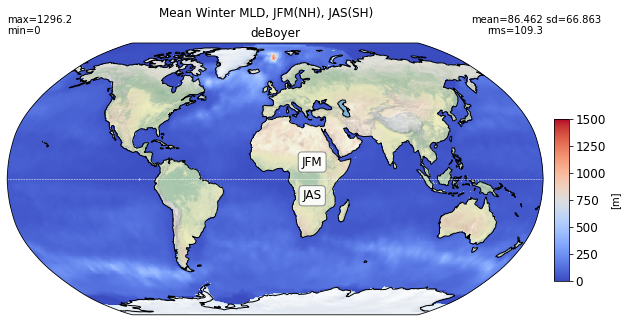

In [5]:
%matplotlib inline

title = 'Mean Winter MLD, JFM(NH), JAS(SH)'
try:
  area= grd[0].area_t
except:
  area= grd[0].areacello
plot_map(obs_winter, area, grd[0], 'deBoyer', 
           vmin=0, vmax=1500, suptitle=title)

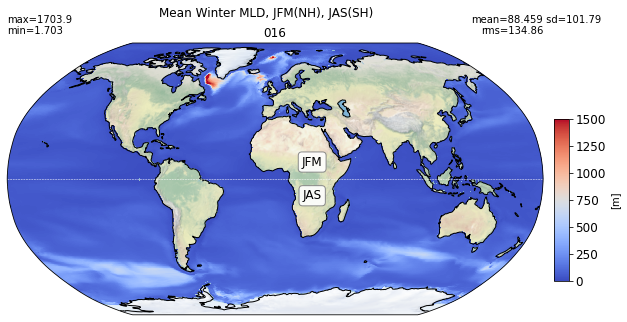

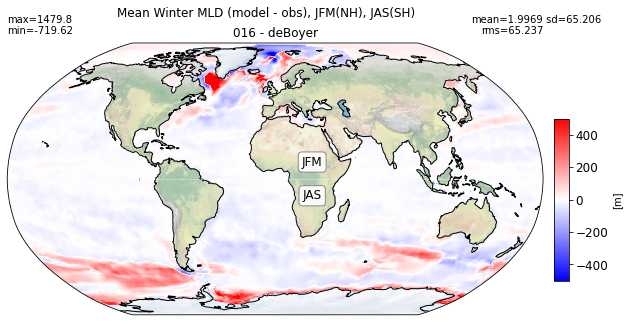

In [6]:
title1 = 'Mean Winter MLD, JFM(NH), JAS(SH)'
title2 = 'Mean Winter MLD (model - obs), JFM(NH), JAS(SH)'

for path, case, i in zip(ocn_path, casename, range(len(casename))):
  da = xr.open_dataset(path+case+'_MLD_winter.nc')
  try:
    area= grd[i].area_t
  except:
    area= grd[i].areacello

  # model
  plot_map(da.MLD_winter.values, area, grd[i], label[i], 
           vmin=0, vmax=1500, suptitle=title1) 
  # model - obs
  diff = (da.MLD_winter.values - obs_winter)
  plot_map(diff, area, grd[i], label[i] + ' - deBoyer', 
           vmin=-500, vmax=500, suptitle=title2, cmap='bwr')

### Summer

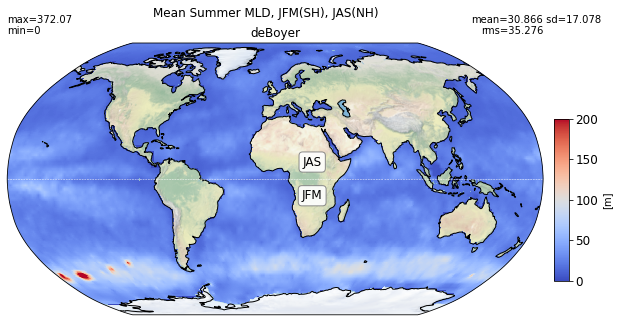

In [7]:
title = 'Mean Summer MLD, JFM(SH), JAS(NH)'
try:
  area= grd[0].area_t
except:
  area= grd[0].areacello
plot_map(obs_summer, area, grd[0], 'deBoyer', vmin=0, vmax=200, 
           suptitle=title, nh='JAS', sh='JFM',)

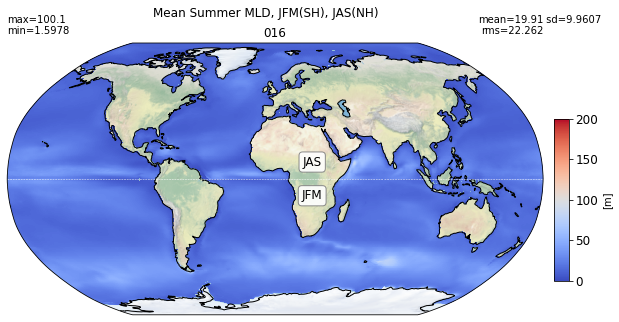

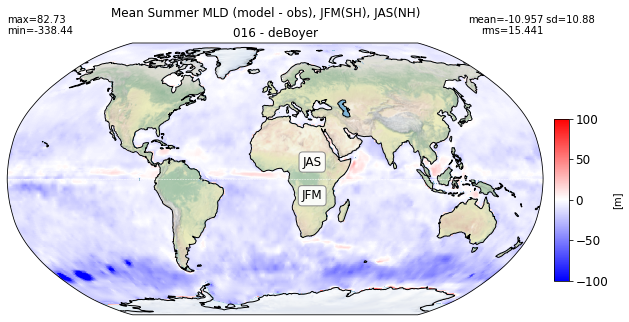

In [8]:
title1 = 'Mean Summer MLD, JFM(SH), JAS(NH)'
title2 = 'Mean Summer MLD (model - obs), JFM(SH), JAS(NH)'

for path, case, i in zip(ocn_path, casename, range(len(casename))):
  da = xr.open_dataset(path+case+'_MLD_summer.nc')
  try:
    area= grd[i].area_t
  except:
    area= grd[i].areacello

  # model
  plot_map(da.MLD_summer.values, area, grd[i], label[i], 
           vmin=0, vmax=200, suptitle=title1, nh='JAS', sh='JFM') 
  # model - obs
  diff = (da.MLD_summer.values - obs_summer)
  plot_map(diff, area, grd[i], label[i] + ' - deBoyer', 
           vmin=-100, vmax=100, suptitle=title2, nh='JAS', 
           sh='JFM',cmap='bwr')

### Boundary layer depth

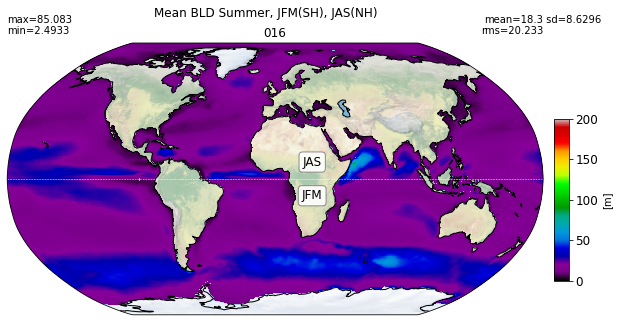

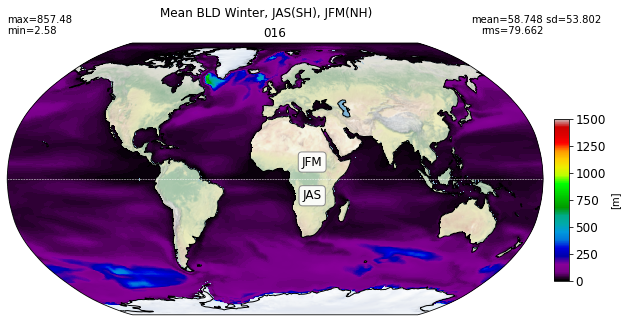

In [9]:
for path, case, i in zip(ocn_path, casename, range(len(casename))):
  ds1 =  xr.open_dataset(path+case+'_BLD_summer.nc')
  ds2 =  xr.open_dataset(path+case+'_BLD_winter.nc')
  summer = np.ma.masked_invalid(ds1.BLD_summer.values)
  winter = np.ma.masked_invalid(ds2.BLD_winter.values)

  try:
    area= grd[i].area_t
  except:
    area= grd[i].areacello
      
  # summer
  plot_map(summer, area, grd[i], label[i], 
           vmin=0, vmax=200, suptitle="Mean BLD Summer, JFM(SH), JAS(NH)", 
           nh='JAS', sh='JFM', cmap='nipy_spectral') 
  # winter
  plot_map(winter, area, grd[i], label[i], 
           vmin=0, vmax=1500, suptitle="Mean BLD Winter, JAS(SH), JFM(NH)",
           cmap='nipy_spectral')